In [1]:
!pip install tensorflow==2.14.0

  Obtaining dependency information for tensorflow==2.14.0 from https://files.pythonhosted.org/packages/e2/7a/c7762c698fb1ac41a7e3afee51dc72aa3ec74ae8d2f57ce19a9cded3a4af/tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for ml-dtypes==0.2.0 from https://files.pythonhosted.org/packages/d1/1d/d5cf76e5e40f69dbd273036e3172ae4a614577cb141673427b80cac948df/ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.7 MB/s eta 0:00:00
  Obtaining dependency information for tensorboard<2.15,>=2.14 from https://files.pythonhosted.org/packages/73/a2/66ed644f6ed1562e0285fcd959af17670ea313c8f331c46f79ee77187eb9/tensorboard-2.14.1-py3-none-any.whl.metadata
  Obtaining dependency information for tensorflow-estimator<2.15,>=2.14.0 from https://files.pythonhosted.org/packages/d1/da/4f264c196325bb6e37a6285caec5b12a03def489b57cc1fdac02bb6272cd/tensor

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
import keras_cv
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

Using TensorFlow backend
2.14.0


In [4]:
# Import other libraries
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

In [5]:
data_files = np.load('/kaggle/input/plants/public_data.npz', allow_pickle=True)
data = data_files['data']
data_gray = np.mean(data, axis=-1)
labels = data_files['labels']

In [6]:
troll_indexes = [58, 95, 137, 138, 171, 207, 338, 412, 434, 486, 506, 529, 571, 599, 622, 658, 692, 701, 723, 725, 753, 779, 783, 827, 840, 880, 898, 901, 961, 971, 974, 989, 1028, 1044, 1064, 1065, 1101, 1149, 1172, 1190, 1191, 1265, 1268, 1280, 1333, 1384, 1443, 1466, 1483, 1528, 1541, 1554, 1594, 1609, 1630, 1651, 1690, 1697, 1752, 1757, 1759, 1806, 1828, 1866, 1903, 1938, 1939, 1977, 1981, 1988, 2022, 2081, 2090, 2150, 2191, 2192, 2198, 2261, 2311, 2328, 2348, 2380, 2426, 2435, 2451, 2453, 2487, 2496, 2515, 2564, 2581, 2593, 2596, 2663, 2665, 2675, 2676, 2727, 2734, 2736, 2755, 2779, 2796, 2800, 2830, 2831, 2839, 2864, 2866, 2889, 2913, 2929, 2937, 3033, 3049, 3055, 3086, 3105, 3108, 3144, 3155, 3286, 3376, 3410, 3436, 3451, 3488, 3490, 3572, 3583, 3666, 3688, 3700, 3740, 3770, 3800, 3801, 3802, 3806, 3811, 3821, 3835, 3862, 3885, 3896, 3899, 3904, 3927, 3931, 3946, 3950, 3964, 3988, 3989, 4049, 4055, 4097, 4100, 4118, 4144, 4150, 4282, 4310, 4314, 4316, 4368, 4411, 4475, 4476, 4503, 4507, 4557, 4605, 4618, 4694, 4719, 4735, 4740, 4766, 4779, 4837, 4848, 4857, 4860, 4883, 4897, 4903, 4907, 4927, 5048, 5080, 5082, 5121, 5143, 5165, 5171]
mask = np.ones(data.shape[0], bool)
mask[troll_indexes] = False
data = data[mask]
labels = labels[mask]

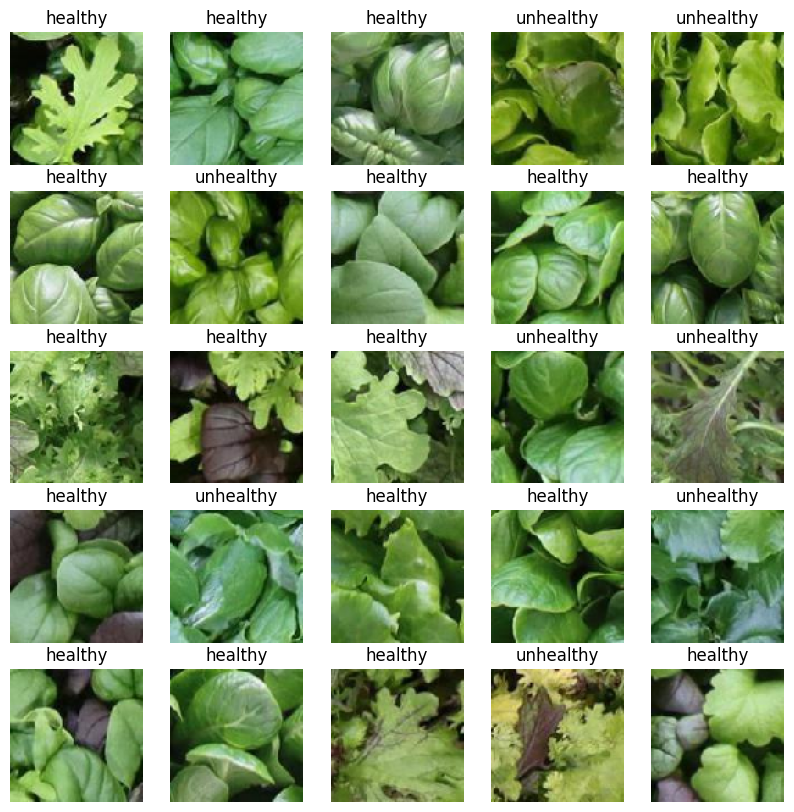

In [7]:
# Number of images to display
num_img = 25

# Create subplots for displaying items
fig, axes = plt.subplots(int(np.sqrt(num_img)),int(np.sqrt(num_img)), figsize=(10,10))
axes = axes.reshape((-1,))
for i in range(num_img):
  axes[i].imshow(data[i]/255,cmap='gray')
  axes[i].set_title(labels[i])
  axes[i].axis('off')


In [8]:
X=data
y=labels

y[labels=="healthy"]=0
y[labels=="unhealthy"]=1

In [9]:
# Clone some unealthy images to balance the dataset
missing_images = np.sum(y == 0) - np.sum(y == 1)
image_indexes = np.where(y==1)[:missing_images]

cloned_images = X[image_indexes]
cloned_labels = y[image_indexes]

X = np.concatenate((X, cloned_images))
y = np.concatenate((y, cloned_labels))

In [10]:
# Convert labels to one-hot encoding format
y = tfk.utils.to_categorical(y,2)

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=0.1, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test), stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (5525, 96, 96, 3), y_train shape: (5525, 2)
X_val shape: (691, 96, 96, 3), y_val shape: (691, 2)
X_test shape: (691, 96, 96, 3), y_test shape: (691, 2)


In [11]:
from tensorflow.keras.applications.convnext import preprocess_input

# Create MobileNetV2 model with specified settings
base_model = tfk.applications.convnext.ConvNeXtXLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

# Display the model architecture with input shapes
# tfk.utils.plot_model(base_model, show_shapes=True)

1393257616/1393257616 [==============================] - 40s 0us/step


In [12]:
# Unfreeze the last layers of mobilenet
base_model.trainable = True
N = 290
for i, layer in enumerate(base_model.layers[:N]):
  layer.trainable=False

base_model.summary()

Model: "convnext_xlarge"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 convnext_xlarge_prestem_no  (None, 96, 96, 3)            0         ['input_1[0][0]']             
 rmalization (Normalization                                                                       
 )                                                                                                
                                                                                                  
 convnext_xlarge_stem (Sequ  (None, 24, 24, 256)          13056     ['convnext_xlarge_prestem_norm
 ential)                                                            alization[0][0]'

# SimSiam

In [13]:
CROP_TO = 32


def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = tf.clip_by_value(x, 0, 255)
    return x


def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, 0.5, 1.5)
    image = tf.image.resize_with_crop_or_pad(image, 110, 110)
    image = tf.image.random_crop(image, (96, 96, 3))
    image = random_apply(color_jitter, image, p=0.8)
    return image

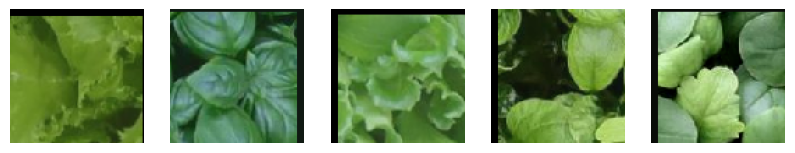

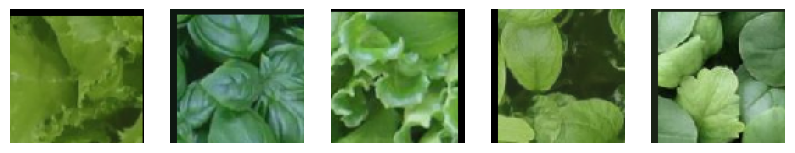

In [14]:
BATCH_SIZE = 128
SEED = 0


ssl_ds_one = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

# Visualize a few augmented images.
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(5):
    ax = plt.subplot(1, 5, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

# Ensure that the different versions of the dataset actually contain
# identical images.
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(5):
    ax = plt.subplot(1, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()


In [15]:
N = 2
DEPTH = N * 9 + 2
NUM_BLOCKS = ((DEPTH - 2) // 9) - 1
PROJECT_DIM = 2048
LATENT_DIM = 512
WEIGHT_DECAY = 0.0005


def get_encoder():
    # Input and backbone.
    inputs = tfkl.Input((96, 96, 3))
    x = base_model(inputs)

    # Projection head.
    x = tfkl.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=tfk.regularizers.l2(WEIGHT_DECAY)
    )(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)
    x = tfkl.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=tfk.regularizers.l2(WEIGHT_DECAY)
    )(x)
    outputs = tfkl.BatchNormalization()(x)
    return tf.keras.Model(inputs, outputs, name="encoder")


def get_predictor():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            tfkl.Input((PROJECT_DIM,)),
            tfkl.Dense(
                LATENT_DIM,
                use_bias=False,
                kernel_regularizer=tfk.regularizers.l2(WEIGHT_DECAY),
            ),
            tfkl.ReLU(),
            tfkl.BatchNormalization(),
            tfkl.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model


In [16]:
def compute_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))


In [17]:
class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super().__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


Epoch 1/200
44/44 [==============================] - 102s 1s/step - loss: -0.4909
Epoch 2/200
44/44 [==============================] - 57s 1s/step - loss: -0.8167
Epoch 3/200
44/44 [==============================] - 56s 1s/step - loss: -0.8608
Epoch 4/200
44/44 [==============================] - 56s 1s/step - loss: -0.8754
Epoch 5/200
44/44 [==============================] - 57s 1s/step - loss: -0.8831
Epoch 6/200
44/44 [==============================] - 57s 1s/step - loss: -0.8884
Epoch 7/200
44/44 [==============================] - 56s 1s/step - loss: -0.8918
Epoch 8/200
44/44 [==============================] - 56s 1s/step - loss: -0.8947
Epoch 9/200
44/44 [==============================] - 57s 1s/step - loss: -0.8967
Epoch 10/200
44/44 [==============================] - 56s 1s/step - loss: -0.8981
Epoch 11/200
44/44 [==============================] - 56s 1s/step - loss: -0.8993
Epoch 12/200
44/44 [==============================] - 56s 1s/step - loss: -0.9008
Epoch 13/200
44/44 [====

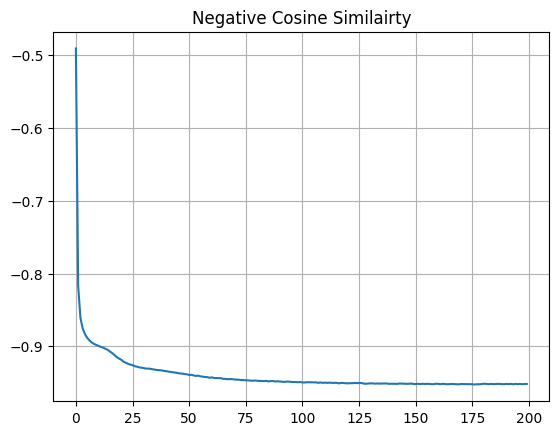

In [18]:
EPOCHS = 200

num_training_samples = len(X_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=30, restore_best_weights=True
)

# Compile model and start training.
simsiam = SimSiam(get_encoder(), get_predictor())
simsiam.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
history = simsiam.fit(ssl_ds, epochs=EPOCHS, callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

In [19]:
try:
    inputs = tfk.Input(shape=(96, 96, 3))
    outputs = base_model(inputs)

    efficientnetsimsiam = tfk.Model(inputs=inputs, outputs=outputs, name='efficientnetsimsiam')
    efficientnetsimsiam.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
    efficientnetsimsiam.save('/kaggle/working/EfficientNetSimSiam.keras')
except:
    print("Did not save weights")

# Train the model

In [20]:
base_model.trainable = False

# Create an input layer with shape (224, 224, 3)
inputs = tfk.Input(shape=(96, 96, 3))

# Add data augmentation
augmentation = tf.keras.Sequential([
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomContrast(0.5),
    tfkl.RandomZoom(0.3),
    tfkl.RandomRotation((-1,1)),
    tfkl.RandomFlip("horizontal_and_vertical"),
], name='augmentation')
x = augmentation(inputs)

preprocessing = tfkl.Lambda(lambda x: preprocess_input(x), name="preprocessing")
x = preprocessing(x)

# Connect MobileNetV2 to the input
x = base_model(x, training=False)

# Activation layer
l2_lambda = 2e-5
outputs = tf.keras.Sequential([
    tfkl.Dropout(0.3),
    tfkl.Dense(units=512,kernel_initializer=tfk.initializers.HeUniform(seed=seed),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
    tfkl.Dropout(0.3),
    tfkl.Dense(units=256,kernel_initializer=tfk.initializers.HeUniform(seed=seed),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
    tfkl.Dropout(0.3),
    tfkl.Dense(units=128,kernel_initializer=tfk.initializers.HeUniform(seed=seed),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
    tfkl.Dropout(0.3),
    tfkl.Dense(units=64,kernel_initializer=tfk.initializers.HeUniform(seed=seed),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
    tfkl.Dropout(0.3),
    tfkl.Dense(2, activation='softmax'),
], name='activation')(x)

# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate=1e-3), metrics=['accuracy'])

# Display model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 augmentation (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 preprocessing (Lambda)      (None, 96, 96, 3)         0         
                                                                 
 convnext_xlarge (Functiona  (None, 2048)              348147968 
 l)                                                              
                                                                 
 activation (Sequential)     (None, 2)                 1221698   
                                                                 
Total params: 349369666 (1.30 GB)
Trainable params: 1221698 (4.66 MB)
Non-trainable params: 348147968 (1.30 GB)
_______________

In [21]:
# Train the model
history = model.fit(
    x = X_train, # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 256,
    epochs = 1000,
    validation_data = (X_val, y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=5, factor=0.999,mode='max',min_lr=1e-5)
    ]
).history

Epoch 1/1000
22/22 [==============================] - 73s 2s/step - loss: 1.0706 - accuracy: 0.5245 - val_loss: 0.7134 - val_accuracy: 0.6035 - lr: 0.0010
Epoch 2/1000
22/22 [==============================] - 31s 1s/step - loss: 0.7412 - accuracy: 0.5765 - val_loss: 0.7155 - val_accuracy: 0.5557 - lr: 0.0010
Epoch 3/1000
22/22 [==============================] - 32s 1s/step - loss: 0.6826 - accuracy: 0.6246 - val_loss: 0.6346 - val_accuracy: 0.7062 - lr: 0.0010
Epoch 4/1000
22/22 [==============================] - 31s 1s/step - loss: 0.6232 - accuracy: 0.6979 - val_loss: 0.6537 - val_accuracy: 0.6368 - lr: 0.0010
Epoch 5/1000
22/22 [==============================] - 31s 1s/step - loss: 0.5809 - accuracy: 0.7274 - val_loss: 0.6301 - val_accuracy: 0.6700 - lr: 0.0010
Epoch 6/1000
22/22 [==============================] - 31s 1s/step - loss: 0.5692 - accuracy: 0.7323 - val_loss: 0.6020 - val_accuracy: 0.7019 - lr: 0.0010
Epoch 7/1000
22/22 [==============================] - 32s 1s/step - lo

In [22]:
test_acc = np.mean(np.argmax(model.predict(X_test), axis=-1) == np.argmax(y_test, axis=-1))
test_acc

22/22 [==============================] - 13s 323ms/step


0.8842257597684515

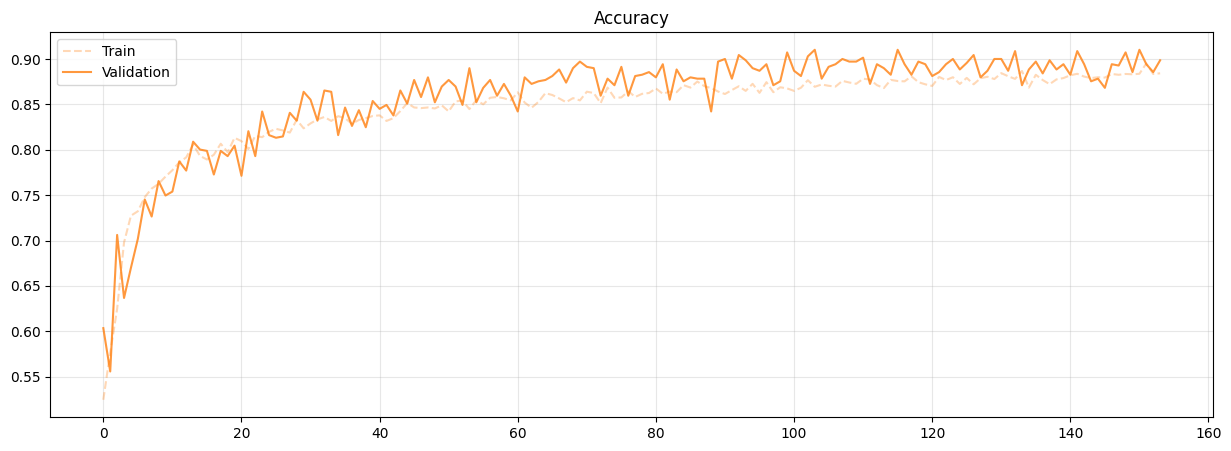

In [23]:
plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Train', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [24]:
model.save('/kaggle/working/TransferLearningAZ')

# Fine Tuning (wasn't run for the final model)

In [25]:
# List all the layers in the backbone model
for i, layer in enumerate(model.get_layer('convnext_xlarge').layers):
    print(i, layer)

0 <keras.src.engine.input_layer.InputLayer object at 0x7bdb1ff2e0e0>
1 <keras.src.layers.preprocessing.normalization.Normalization object at 0x7bdb1ff2dc00>
2 <keras.src.engine.sequential.Sequential object at 0x7bdb1fef7d60>
3 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7bdb200cf370>
4 <keras.src.layers.normalization.layer_normalization.LayerNormalization object at 0x7bdb200cc070>
5 <keras.src.layers.core.dense.Dense object at 0x7bdb1ff8e9e0>
6 <keras.src.layers.core.activation.Activation object at 0x7bdb1ff8fca0>
7 <keras.src.layers.core.dense.Dense object at 0x7bdb1ff8f3a0>
8 <keras.src.applications.convnext.LayerScale object at 0x7bdb1c2fe4d0>
9 <keras.src.layers.core.activation.Activation object at 0x7bdb1c2fcfd0>
10 <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x7bdb1c2fe470>
11 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7bdb1c2fe260>
12 <keras.src.layers.normalization.layer_normalization.LayerNormalization object at 0x7bdb1c2ff670>
13 <kera

In [26]:
# Unfreeze the last layers of the network to fine tune them
base_model.trainable = True
N = 280
for i, layer in enumerate(base_model.layers[:N]):
  layer.trainable=False

model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')
model.summary()

In [27]:
# Train the model
history = model.fit(
    x = X_train, # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 256,
    epochs = 2000,
    validation_data = (X_val, y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=200, restore_best_weights=True)]
).history

In [28]:
# Compute the accuracy against our test set to compare this model
# to other models
test_acc = np.mean(np.argmax(model.predict(X_test), axis=-1) == np.argmax(y_test, axis=-1))
test_acc

In [29]:
# Save the model
model.save(f'/kaggle/working/FineTuned')

In [30]:
# Plot the training and validation accuracy
plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Train', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()